### **Desafio de Ciência de Dados — PProductions**

Objetivo

Explorar os dados, levantar hipóteses e construir modelos preditivos que ajudem a:

- entender o que impulsiona faturamento e avaliação de filmes;

- recomendar um tipo de filme para um público genérico;

- estimar a nota do IMDb de novos títulos;

- tirar insights de texto a partir das sinopses (“Overview”).


Diciónario dos dados:

- Series_Title – Nome do filme
- Released_Year - Ano de lançamento
- Certificate - Classificação etária
- Runtime – Tempo de duração
- Genre - Gênero
- IMDB_Rating - Nota do IMDB
- Overview - Overview do filme
- Meta_score - Média ponderada de todas as críticas 
- Director – Diretor
- Star1 - Ator/atriz #1
- -Star2 - Ator/atriz #2
- Star3 - Ator/atriz #3
- Star4 - Ator/atriz #4
- No_of_Votes - Número de votos
- Gross - Faturamento



In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import os, json, joblib, sklearn
from datetime import datetime
import sys
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.stats import shapiro
from scipy.stats import f_oneway

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

FILE_PATH = os.environ.get('IMDB_CSV', '/home/josiele/Projeto Pessoal/LH_CD_JOSIELE/dados/imdb.csv')
df = pd.read_csv(FILE_PATH)
print('Shape:', df.shape)
df.head(5)

Shape: (999, 16)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [3]:
print("Shape:", df.shape)
print("\nTipos de dados:")
print(df.dtypes)

Shape: (999, 16)

Tipos de dados:
Unnamed: 0         int64
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object


In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
results = []
for col in numeric_cols:
    data = df[col].dropna()
    if len(data) > 3:
        stat, p = shapiro(data)
        results.append({
            "Column": col,
            "W-Statistic": stat,
            "p-value": p,
            "Normal?": "Yes" if p > 0.05 else "No"
        })

df_normality = pd.DataFrame(results).sort_values(by="Normal?", ascending=False)
print(df_normality.to_string(index=False))

     Column  W-Statistic      p-value Normal?
 Unnamed: 0     0.954809 5.507352e-17      No
IMDB_Rating     0.923348 3.930949e-22      No
 Meta_score     0.974964 7.763505e-11      No
No_of_Votes     0.740920 8.450721e-37      No


In [5]:
print("\nResumo numérico:")
print(df.describe(include=[np.number]).T)


Resumo numérico:
             count           mean            std      min      25%       50%       75%        max
Unnamed: 0   999.0     500.000000     288.530761      1.0    250.5     500.0     749.5      999.0
IMDB_Rating  999.0       7.947948       0.272290      7.6      7.7       7.9       8.1        9.2
Meta_score   842.0      77.969121      12.383257     28.0     70.0      79.0      87.0      100.0
No_of_Votes  999.0  271621.422422  320912.621055  25088.0  55471.5  138356.0  373167.5  2303232.0


In [6]:
print("\nResumo categórico:")
print(df.describe(include=['object']).T)


Resumo categórico:
              count unique                                                top freq
Series_Title    999    998                                           Drishyam    2
Released_Year   999    100                                               2014   32
Certificate     898     16                                                  U  234
Runtime         999    140                                            100 min   23
Genre           999    202                                              Drama   84
Overview        999    999  An organized crime dynasty's aging patriarch t...    1
Director        999    548                                   Alfred Hitchcock   14
Star1           999    659                                          Tom Hanks   12
Star2           999    840                                        Emma Watson    7
Star3           999    890                                       Rupert Grint    5
Star4           999    938                                      Mic

In [7]:
print("\nPercentual de nulos:")
print((df.isna().mean() * 100).round(2).sort_values(ascending=False))


Percentual de nulos:
Gross            16.92
Meta_score       15.72
Certificate      10.11
Unnamed: 0        0.00
Runtime           0.00
Genre             0.00
Series_Title      0.00
Released_Year     0.00
Overview          0.00
IMDB_Rating       0.00
Star1             0.00
Director          0.00
Star2             0.00
Star3             0.00
Star4             0.00
No_of_Votes       0.00
dtype: float64


In [8]:
tokens = (
    df["Genre"]
    .dropna()
    .astype(str)
    .str.split(r"[,\|/]+")         
    .explode()
    .str.strip()
    .replace("", pd.NA)
    .dropna()
    .str.title()                     
)

tokens_unique = sorted(tokens.unique())
print(f"\nTotal de gêneros únicos (tokens): {len(tokens_unique)}")
print("Lista de gêneros únicos:", tokens_unique)
token_counts = tokens.value_counts().reset_index()
token_counts.columns = ["Genre", "count"]
display(token_counts)


Total de gêneros únicos (tokens): 21
Lista de gêneros únicos: ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


,Genre,count
0,Drama,723
1,Comedy,233
2,Crime,209
3,Adventure,196
4,Action,189
5,Thriller,137
6,Romance,125
7,Biography,109
8,Mystery,99
9,Animation,82


#### ANÁLISE UNIVARIADA

Número total de filmes: 998
Títulos duplicados: 1


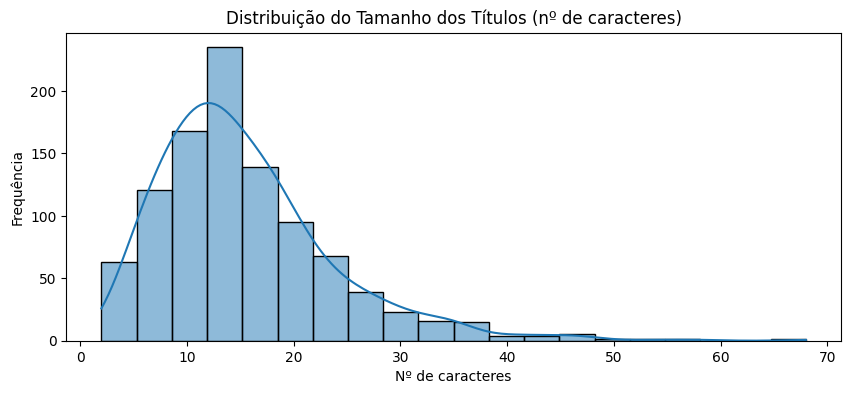

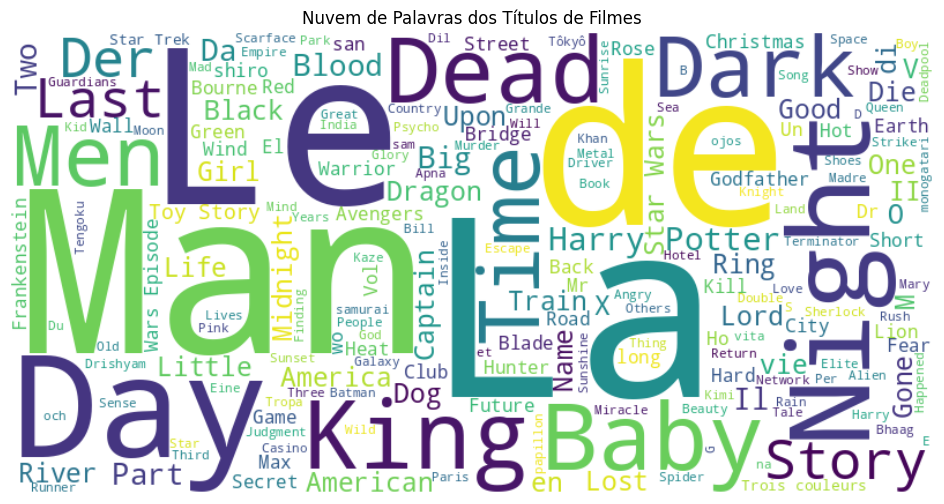

In [9]:
print("Número total de filmes:", df["Series_Title"].nunique())
print("Títulos duplicados:", df["Series_Title"].duplicated().sum())

df["title_length"] = df["Series_Title"].astype(str).apply(len)
plt.figure(figsize=(10,4))
sns.histplot(df["title_length"], bins=20, kde=True)
plt.title("Distribuição do Tamanho dos Títulos (nº de caracteres)")
plt.xlabel("Nº de caracteres")
plt.ylabel("Frequência")
plt.show()

text_titles = " ".join(df["Series_Title"].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_titles)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras dos Títulos de Filmes")
plt.show()


- Títulos curtos e com palavras de impacto parecem estar associados a maior presença no dataset, possivelmente um padrão de marketing para atrair atenção.

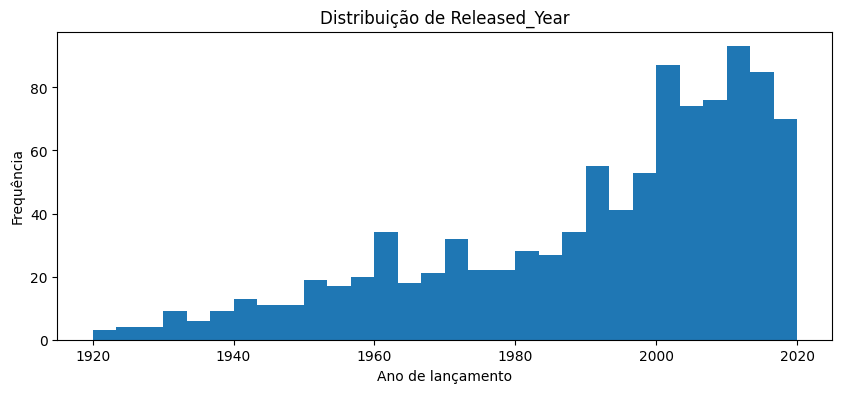

In [10]:
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")

plt.figure(figsize=(10,4))
plt.hist(df["Released_Year"].dropna(), bins=30)
plt.title("Distribuição de Released_Year")
plt.xlabel("Ano de lançamento")
plt.ylabel("Frequência")
plt.show()


- O dataset concentra-se fortemente em filmes lançados após 1980, com aumento contínuo até os anos 2000. O pico ocorre entre 2000 e 2010, indicando maior presença de produções recentes.

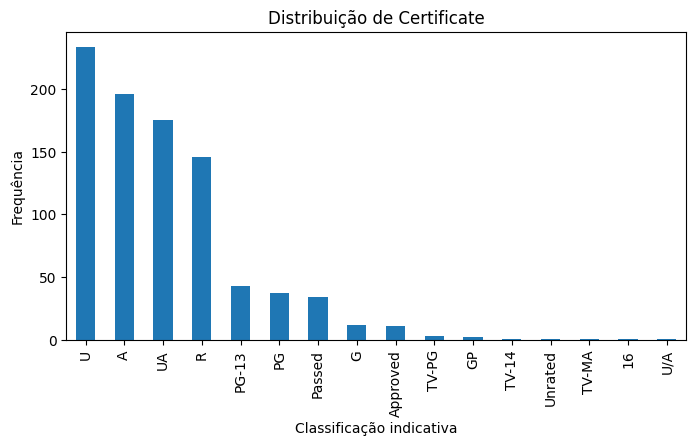

In [11]:
plt.figure(figsize=(8,4))
df["Certificate"].value_counts().plot(kind="bar")
plt.title("Distribuição de Certificate")
plt.xlabel("Classificação indicativa")
plt.ylabel("Frequência")
plt.show()


- A maioria dos filmes é U(Universal), A ou UA, ou seja, voltados para públicos amplos. Filmes R(restritos) também têm presença relevante, mas bem menor. Certificações menos comuns (PG-13, G, TV-MA, Unrated) aparecem em proporções muito baixas.

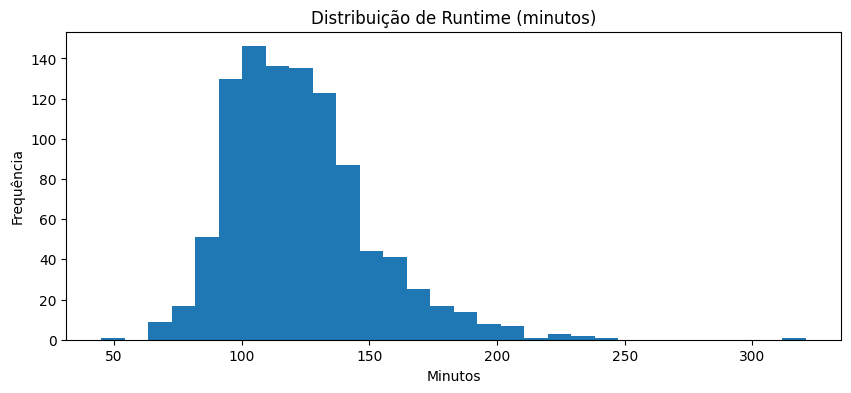

In [12]:
df["Runtime_min"] = df["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)

plt.figure(figsize=(10,4))
plt.hist(df["Runtime_min"].dropna(), bins=30)
plt.title("Distribuição de Runtime (minutos)")
plt.xlabel("Minutos")
plt.ylabel("Frequência")
plt.show()


- A maioria dos filmes tem entre 90 e 140 minutos, faixa típica de longas-metragens comerciais. Há poucos outliers acima de 200 minutos (épicos, produções especiais). Filmes muito curtos (< 60 min) são raros, reforçando o foco em longas tradicionais.

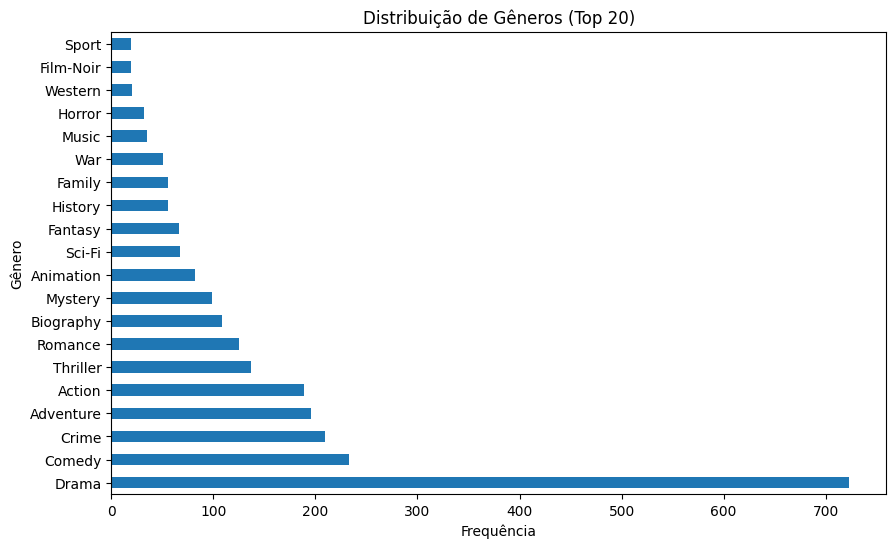

In [13]:
genres = (
    df["Genre"].dropna()
    .astype(str).str.split(",")
    .explode().str.strip()
)

plt.figure(figsize=(10,6))
genres.value_counts().head(20).plot(kind="barh")
plt.title("Distribuição de Gêneros (Top 20)")
plt.xlabel("Frequência")
plt.ylabel("Gênero")
plt.show()


- Drama domina amplamente o dataset, seguido por Comedy e Crime. Gêneros de grande apelo popular (Action, Adventure, Thriller) também aparecem bem representados. Nichos como Sport, Film-Noir e Western têm presença mínima.

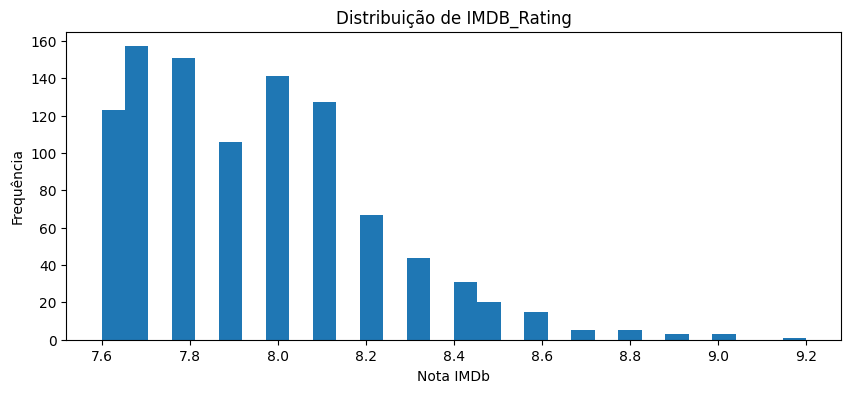

In [14]:
plt.figure(figsize=(10,4))
plt.hist(df["IMDB_Rating"].dropna(), bins=30)
plt.title("Distribuição de IMDB_Rating")
plt.xlabel("Nota IMDb")
plt.ylabel("Frequência")
plt.show()


- A maior parte dos filmes concentra-se entre 7.6 e 8.2 pontos. Poucos títulos ultrapassam 8.5, mostrando que notas muito altas são raras. A cauda direita indica que apenas filmes excepcionais chegam próximos a 9.0.

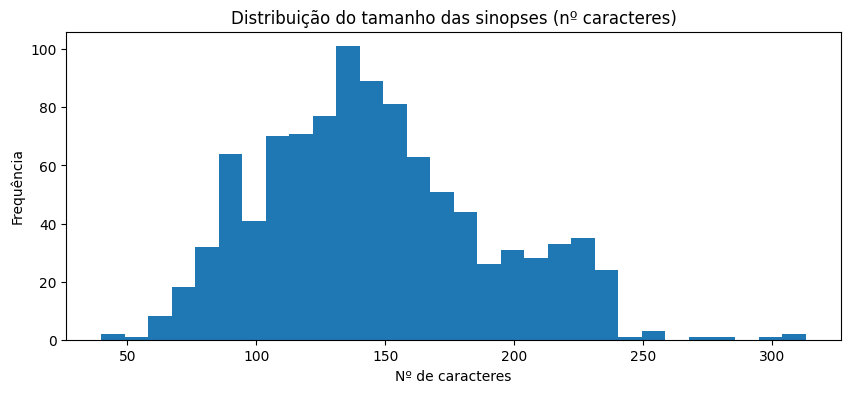

In [15]:
df["overview_length"] = df["Overview"].astype(str).apply(len)
plt.figure(figsize=(10,4))
plt.hist(df["overview_length"], bins=30)
plt.title("Distribuição do tamanho das sinopses (nº caracteres)")
plt.xlabel("Nº de caracteres")
plt.ylabel("Frequência")
plt.show()


- A maioria das sinopses tem entre 100 e 180 caracteres, sugerindo descrições curtas e objetivas, poucas sinopses ultrapassam 250 caracteres, caracterizando outliers mais descritivos.

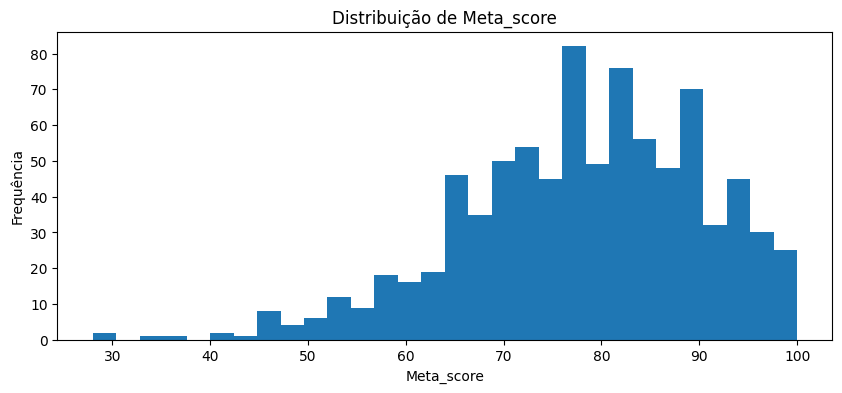

In [16]:
plt.figure(figsize=(10,4))
plt.hist(df["Meta_score"].dropna(), bins=30)
plt.title("Distribuição de Meta_score")
plt.xlabel("Meta_score")
plt.ylabel("Frequência")
plt.show()

- A maior concentração está entre 70 e 90 pontos, faixa típica de avaliações positivas da crítica, poucos filmes ficam abaixo de 50, mostrando que a base tem foco em obras bem avaliadas. Notas próximas de 100 aparecem, mas são raras — reservadas a produções de altíssimo prestígio crítico.

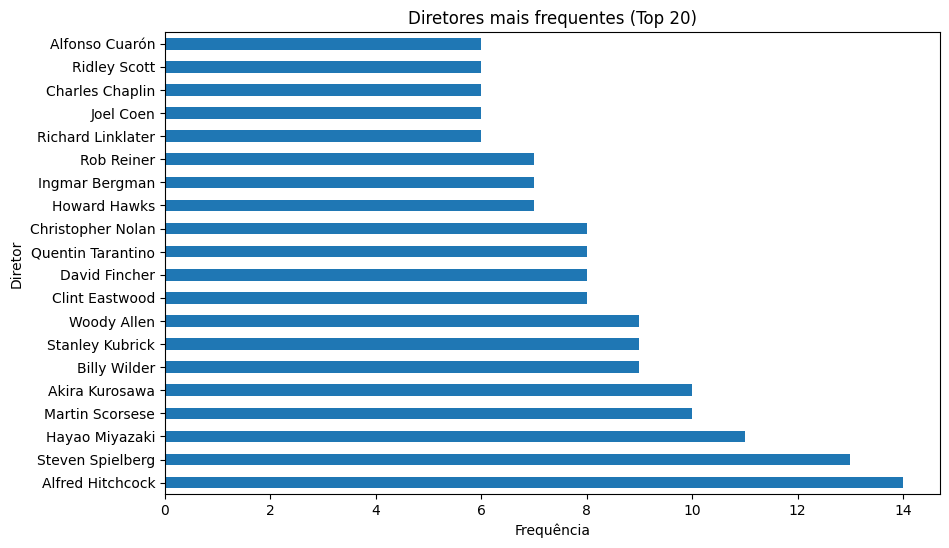

In [17]:
plt.figure(figsize=(10,6))
df["Director"].value_counts().head(20).plot(kind="barh")
plt.title("Diretores mais frequentes (Top 20)")
plt.xlabel("Frequência")
plt.ylabel("Diretor")
plt.show()

- Alfred Hitchcock e Steven Spielberg lideram a lista, confirmando seu peso histórico no cinema. Nomes como Scorsese, Kurosawa, Kubrick e Tarantino também aparecem com alta recorrência, reforçando sua relevância crítica e comercial. Há um equilíbrio entre clássicos consagrados (Chaplin, Bergman, Hawks) e diretores contemporâneos (Nolan, Fincher).

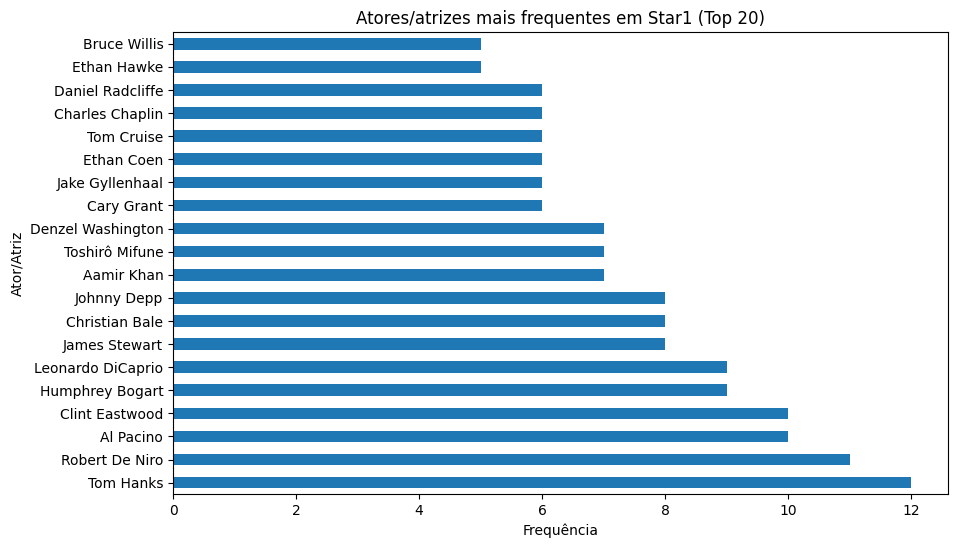

In [18]:
plt.figure(figsize=(10,6))
df["Star1"].value_counts().head(20).plot(kind="barh")
plt.title("Atores/atrizes mais frequentes em Star1 (Top 20)")
plt.xlabel("Frequência")
plt.ylabel("Ator/Atriz")
plt.show()

- Tom Hanks e Robert De Niro lideram, confirmando sua presença marcante em grandes produções. Ícones como Al Pacino, Clint Eastwood e Leonardo DiCaprio também aparecem entre os mais recorrentes.

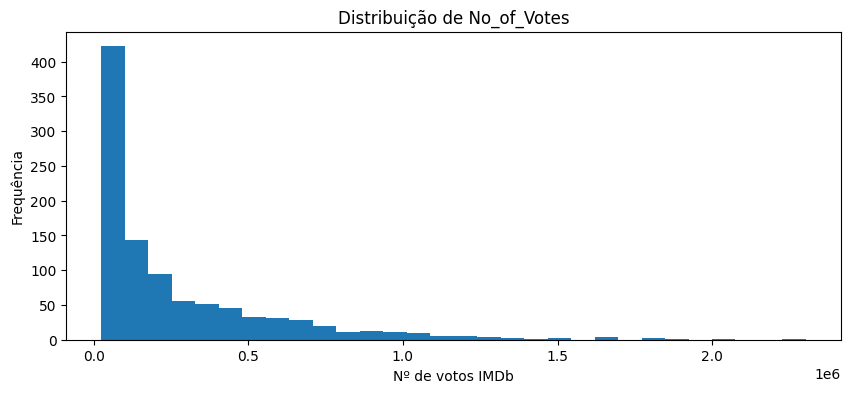

In [19]:
plt.figure(figsize=(10,4))
plt.hist(df["No_of_Votes"].dropna(), bins=30)
plt.title("Distribuição de No_of_Votes")
plt.xlabel("Nº de votos IMDb")
plt.ylabel("Frequência")
plt.show()

- Forte assimetria à direita: a maioria dos filmes tem poucos votos, enquanto poucos títulos concentram milhões. A grande massa está abaixo de 200 mil votos, com raros outliers ultrapassando 2 milhões.

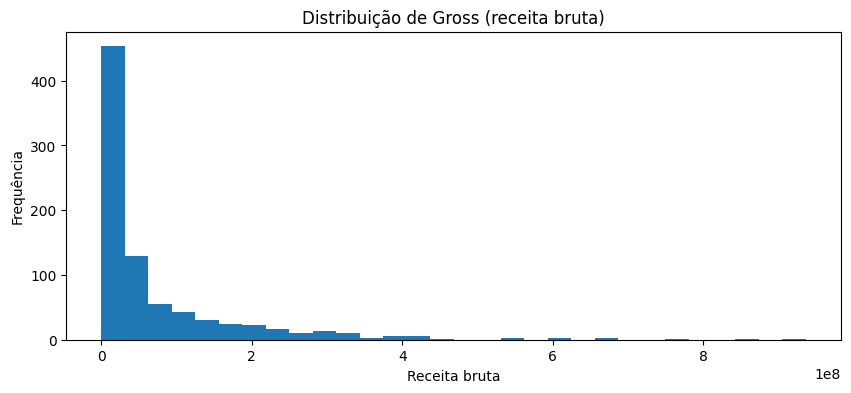

In [20]:
df["Gross_num"] = (
    df["Gross"].astype(str)
    .str.replace(r"[^0-9.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)
plt.figure(figsize=(10,4))
plt.hist(df["Gross_num"].dropna(), bins=30)
plt.title("Distribuição de Gross (receita bruta)")
plt.xlabel("Receita bruta")
plt.ylabel("Frequência")
plt.show()

- Forte assimetria à direita: a maioria dos filmes arrecada pouco, enquanto poucos títulos concentram receitas altíssimas. A maior parte dos filmes está abaixo de 100 milhões de dólares, com raros blockbusters passando de 800 milhões.

In [21]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
results = []
for col in cat_cols:
    try:
        groups = [df.loc[df[col] == cat, 'IMDB_Rating'].dropna()
                  for cat in df[col].dropna().unique()]

        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            results.append({"Feature": col,
                            "F-statistic": f_stat,
                            "p-value": p_val})
    except Exception as e:
        print(f"Skipped {col} due to error: {e}")

anova_results = pd.DataFrame(results).sort_values(by="p-value")
print(anova_results)

significant = anova_results[anova_results["p-value"] < 0.05]
print("\nSignificant categorical features associated with SalePrice:")
print(significant)

       Feature  F-statistic   p-value
0  Certificate     3.593106  0.000108
1      Runtime     1.629921  0.000171
3     Director     1.521798  0.000186
4        Star1     1.550190  0.000490
7        Star4     2.393866  0.000494
2        Genre     1.161963  0.120978
6        Star3     1.237481  0.149408
5        Star2     1.143702  0.217893
8        Gross     0.551218  0.704097

Significant categorical features associated with SalePrice:
       Feature  F-statistic   p-value
0  Certificate     3.593106  0.000108
1      Runtime     1.629921  0.000171
3     Director     1.521798  0.000186
4        Star1     1.550190  0.000490
7        Star4     2.393866  0.000494


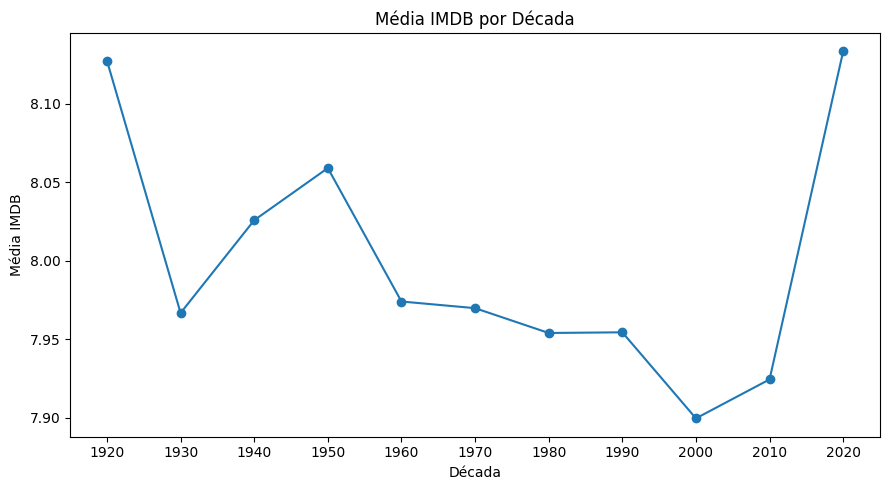

In [22]:
df_dec = df.copy()
df_dec["Released_Year"] = pd.to_numeric(df_dec["Released_Year"], errors="coerce")
df_dec = df_dec.dropna(subset=["Released_Year"])
df_dec = df_dec[df_dec["Released_Year"].between(1900, 2025)]  
df_dec["Decade"] = (df_dec["Released_Year"].astype(int) // 10) * 10

by_decade = (
    df_dec.groupby("Decade", as_index=False)
          .agg(IMDB_Mean=("IMDB_Rating", "mean"),
               n_titles=("IMDB_Rating", "size"))
          .sort_values("Decade")
)

decade_labels = by_decade["Decade"].astype(int).astype(str)

def lineplot(x, y, title, xlabel, ylabel):
    fig = plt.figure(figsize=(9,5))
    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

lineplot(decade_labels,
         by_decade["IMDB_Mean"],
         "Média IMDB por Década",
         "Década",
         "Média IMDB")

- As notas se mantêm estáveis em torno de 8.0, sem grandes oscilações ao longo de 100 anos.

- Décadas de 1920 e 2020 aparecem com médias ligeiramente mais altas, mas possivelmente por amostra pequena.

- Entre 1960 e 2000 há uma leve queda, sugerindo maior heterogeneidade da produção cinematográfica moderna.

#### ANÁLISE BIVARIADA

##### Variavéis númericas

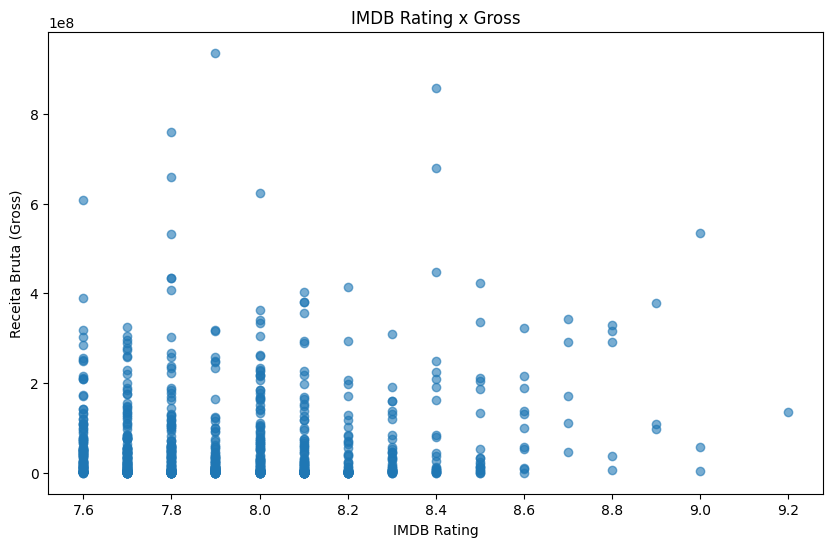

In [23]:
df["Gross_num"] = (
    df["Gross"].astype(str)
    .str.replace(r"[^0-9.]", "", regex=True)
    .replace("", np.nan)
    .astype(float)
)
plt.figure(figsize=(10,6))
plt.scatter(df["IMDB_Rating"], df["Gross_num"], alpha=0.6)
plt.title("IMDB Rating x Gross")
plt.xlabel("IMDB Rating")
plt.ylabel("Receita Bruta (Gross)")
plt.show()

Hipótese: Filmes com maior bilheteria tendem a ter maior nota no IMDb.

- H0: ρ = 0 (não há correlação).

- H1: ρ ≠ 0 (existe correlação).

In [24]:
df["Gross_num"] = (
    df["Gross"].astype(str)
      .str.replace(r"[^0-9.]", "", regex=True)
      .replace("", np.nan)
      .astype(float)
)
tmp = df[["IMDB_Rating", "Gross_num"]].dropna()
x = tmp["IMDB_Rating"].to_numpy()
y = tmp["Gross_num"].to_numpy()
print(f"n pares válidos: {len(tmp)}")

r_p, p_p = pearsonr(x, y)
r_s, p_s = spearmanr(x, y)
print(f"Pearson r = {r_p:.3f}  (p = {p_p:.4f})")
print(f"Spearman ρ = {r_s:.3f} (p = {p_s:.4f})")

n pares válidos: 830
Pearson r = 0.099  (p = 0.0042)
Spearman ρ = -0.050 (p = 0.1503)


Insights:

- O gráfico mostra dispersão ampla, sem tendência clara entre bilheteria e nota.

- Pearson r = 0.099 (p = 0.0042): existe correlação positiva, mas muito fraca e de baixa relevância prática.

- Spearman ρ = -0.050 (p = 0.1503): não há correlação monotônica significativa.

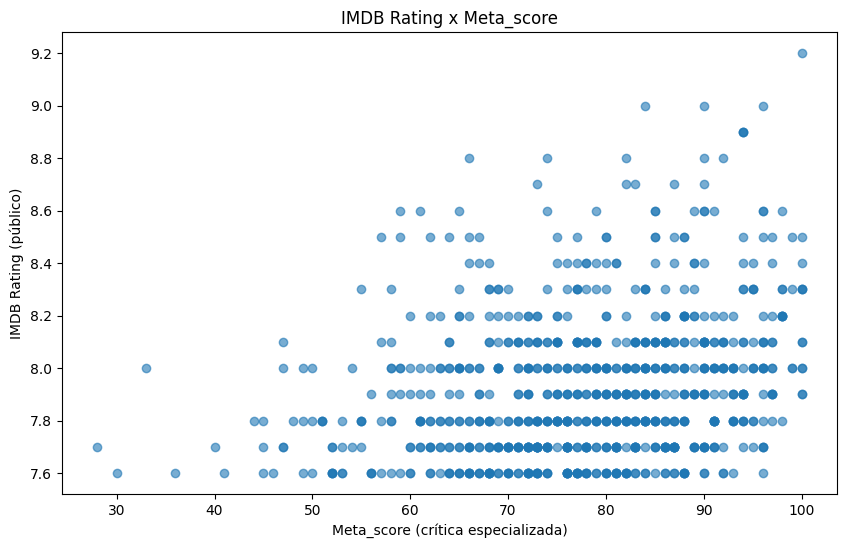

In [25]:
plt.figure(figsize=(10,6))
plt.scatter(df["Meta_score"], df["IMDB_Rating"], alpha=0.6)
plt.title("IMDB Rating x Meta_score")
plt.xlabel("Meta_score (crítica especializada)")
plt.ylabel("IMDB Rating (público)")
plt.show()

Hipótese: Filmes melhor avaliados pela crítica (Meta_score) também têm maior nota no IMDb.

- H0: ρ = 0 (não há correlação).

- H1: ρ ≠ 0 (existe correlação).

In [26]:
df["IMDB_Rating"] = pd.to_numeric(df["IMDB_Rating"], errors="coerce")
df["Meta_score"]  = pd.to_numeric(df["Meta_score"],  errors="coerce")
tmp = df[["IMDB_Rating", "Meta_score"]].dropna().copy()
print("n pares válidos:", len(tmp))
print("n únicos IMDB_Rating:", tmp["IMDB_Rating"].nunique(), 
      "| n únicos Meta_score:", tmp["Meta_score"].nunique())

x = tmp["Meta_score"].to_numpy()
y = tmp["IMDB_Rating"].to_numpy()
r_p, p_p = pearsonr(x, y)
r_s, p_s = spearmanr(x, y)
print(f"Pearson:  r = {r_p:.3f}  (p = {p_p:.4f})")
print(f"Spearman: ρ = {r_s:.3f}  (p = {p_s:.4f})")

n pares válidos: 842
n únicos IMDB_Rating: 16 | n únicos Meta_score: 63
Pearson:  r = 0.271  (p = 0.0000)
Spearman: ρ = 0.285  (p = 0.0000)


Insights:
- O gráfico mostra uma tendência positiva clara: filmes com maiores Meta_score também tendem a ter maiores notas no IMDb.

- Pearson r = 0.271 (p < 0.001) e Spearman ρ = 0.285 (p < 0.001) confirmam uma correlação positiva fraca, porém significativa.

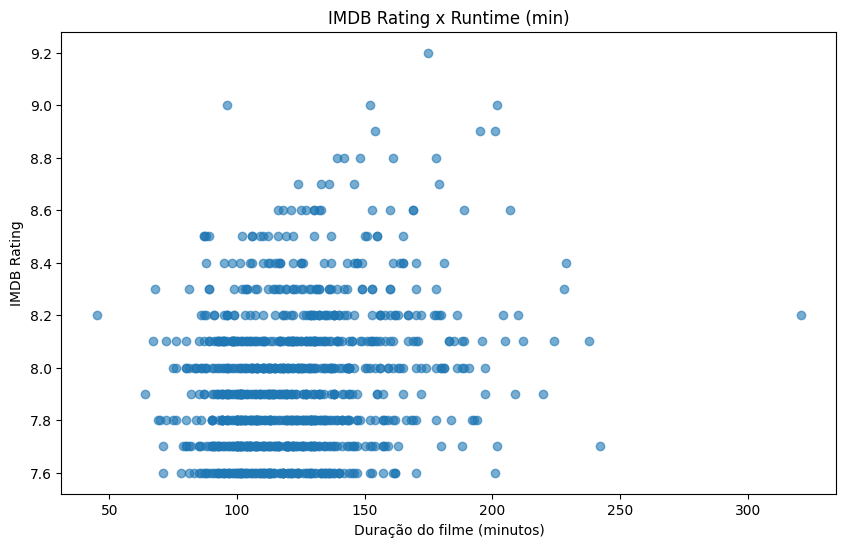

In [27]:
df["Runtime_min"] = df["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)
plt.figure(figsize=(10,6))
plt.scatter(df["Runtime_min"], df["IMDB_Rating"], alpha=0.6)
plt.title("IMDB Rating x Runtime (min)")
plt.xlabel("Duração do filme (minutos)")
plt.ylabel("IMDB Rating")
plt.show()

Hipótese: Filmes mais longos têm avaliações mais altas no IMDb.

- H0: ρ = 0 (não há correlação).

- H1: ρ ≠ 0 (existe correlação).

In [28]:
x = df["IMDB_Rating"].dropna()
y = df["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)[0].dropna()
pearson_corr, pearson_p = pearsonr(x[:len(y)], y)
spearman_corr, spearman_p = spearmanr(x[:len(y)], y)

print(f"Pearson: r={pearson_corr:.3f}, p={pearson_p:.4f}")
print(f"Spearman: r={spearman_corr:.3f}, p={spearman_p:.4f}")

Pearson: r=0.243, p=0.0000
Spearman: r=0.210, p=0.0000


Insigts:

- O gráfico mostra que filmes de diferentes durações têm boa variação de notas, mas há tendência leve de ratings mais altos em filmes com 120–180 minutos.

- Pearson r = 0.243 (p < 0.001) e Spearman ρ = 0.210 (p < 0.001) confirmam uma correlação positiva fraca, porém significativa.

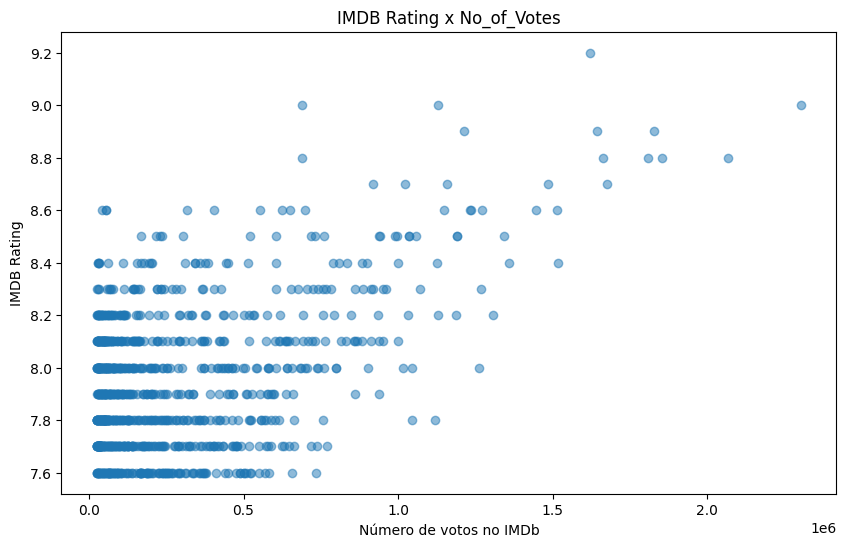

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(df["No_of_Votes"], df["IMDB_Rating"], alpha=0.5)
plt.title("IMDB Rating x No_of_Votes")
plt.xlabel("Número de votos no IMDb")
plt.ylabel("IMDB Rating")
plt.show()

Hipótese: Filmes com mais votos têm maior nota média.

- H0: ρ = 0 (não há correlação).

- H1: ρ ≠ 0 (existe correlação).

In [30]:
x = df["IMDB_Rating"].dropna()
y = df["No_of_Votes"].dropna()
pearson_corr, pearson_p = pearsonr(x[:len(y)], y)
spearman_corr, spearman_p = spearmanr(x[:len(y)], y)

print(f"Pearson: r={pearson_corr:.3f}, p={pearson_p:.4f}")
print(f"Spearman: r={spearman_corr:.3f}, p={spearman_p:.4f}")

Pearson: r=0.479, p=0.0000
Spearman: r=0.212, p=0.0000


Insights:
- O gráfico mostra que filmes de diferentes durações apresentam notas variadas, mas há leve tendência de notas mais altas em filmes entre 120 e 180 minutos.

- Pearson r = 0.243 (p < 0.001) e Spearman ρ = 0.210 (p < 0.001) indicam uma correlação positiva fraca, mas significativa.

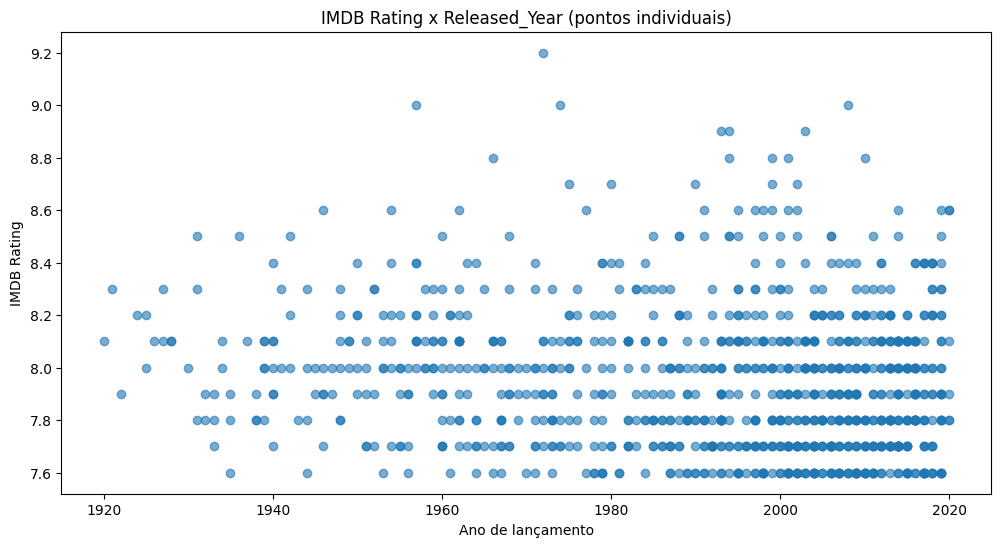

In [31]:
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
plt.figure(figsize=(12,6))
plt.scatter(df["Released_Year"], df["IMDB_Rating"], alpha=0.6)
plt.title("IMDB Rating x Released_Year (pontos individuais)")
plt.xlabel("Ano de lançamento")
plt.ylabel("IMDB Rating")
plt.show()


Hipótese: Filmes mais recentes têm notas diferentes dos clássicos.

- H0: ρ = 0 (não há correlação).

- H1: ρ ≠ 0 (existe correlação).

In [32]:
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
x = df["IMDB_Rating"].dropna()
y = df["Released_Year"].dropna()
pearson_corr, pearson_p = pearsonr(x[:len(y)], y)
spearman_corr, spearman_p = spearmanr(x[:len(y)], y)

print(f"Pearson: r={pearson_corr:.3f}, p={pearson_p:.4f}")
print(f"Spearman: r={spearman_corr:.3f}, p={spearman_p:.4f}")

Pearson: r=-0.133, p=0.0000
Spearman: r=-0.127, p=0.0001


Insights:
- O gráfico mostra que filmes de todas as épocas alcançam boas notas, mas há maior concentração de ratings médios em produções recentes.

- Pearson r = -0.133 (p < 0.001) e Spearman ρ = -0.127 (p < 0.001) indicam uma correlação negativa fraca, porém significativa.

##### Variaveis categóricas

<Figure size 1800x600 with 0 Axes>

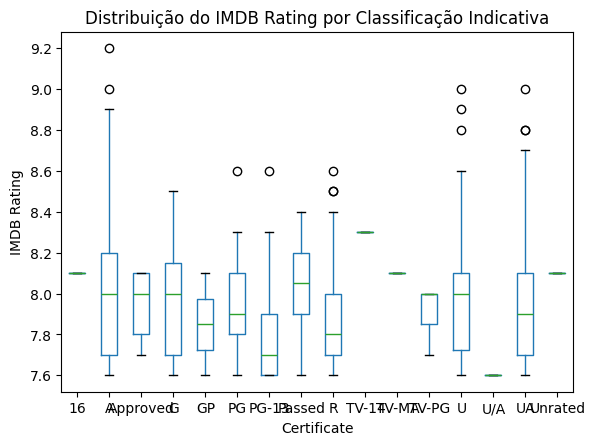

In [33]:
plt.figure(figsize=(18,6))
df.boxplot(column="IMDB_Rating", by="Certificate", grid=False)
plt.title("Distribuição do IMDB Rating por Classificação Indicativa")
plt.suptitle("")  # remove título automático do pandas
plt.xlabel("Certificate")
plt.ylabel("IMDB Rating")
plt.show()

Hipótese: Filmes com classificação indicativa diferente têm médias de nota diferentes.

- H0: médias iguais

- H1: pelo menos uma média diferente

In [34]:
groups = [df.loc[df["Certificate"]==c, "IMDB_Rating"].dropna() 
          for c in df["Certificate"].dropna().unique()]

anova_f, anova_p = f_oneway(*groups)
print(f"ANOVA: F={anova_f:.3f}, p={anova_p:.4f}")


ANOVA: F=2.672, p=0.0005


Insights:

- O boxplot mostra que a mediana das notas é semelhante entre classificações, mas algumas categorias apresentam maior variabilidade (ex.: R e UA). Filmes Approved e A concentram outliers de notas muito altas.

- ANOVA: F=2.672, p=0.0005 → diferenças estatisticamente significativas entre ao menos algumas classificações.

<Figure size 1200x600 with 0 Axes>

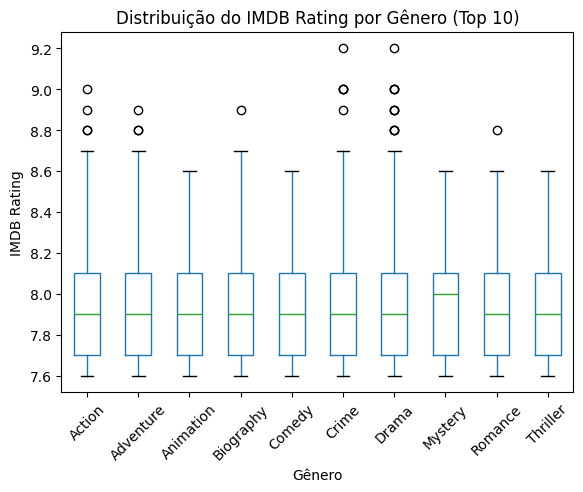

In [35]:
df_genres = (
    df.assign(Genre=df["Genre"].dropna().astype(str).str.split(","))
      .explode("Genre")
)
df_genres["Genre"] = df_genres["Genre"].str.strip()

top_genres = df_genres["Genre"].value_counts().head(10).index
df_top_genres = df_genres[df_genres["Genre"].isin(top_genres)]

plt.figure(figsize=(12,6))
df_top_genres.boxplot(column="IMDB_Rating", by="Genre", grid=False)
plt.title("Distribuição do IMDB Rating por Gênero (Top 10)")
plt.suptitle("")
plt.xlabel("Gênero")
plt.ylabel("IMDB Rating")
plt.xticks(rotation=45)
plt.show()

Hipótese: O gênero influencia na nota IMDb.

- H0: médias iguais

- H1: pelo menos uma diferente

In [36]:
df_genres = (
    df.assign(Genre=df["Genre"].dropna().astype(str).str.split(","))
      .explode("Genre")
)
df_genres["Genre"] = df_genres["Genre"].str.strip()

top_genres = df_genres["Genre"].value_counts().head(5).index
groups = [df_genres.loc[df_genres["Genre"]==g, "IMDB_Rating"].dropna()
          for g in top_genres]

anova_f, anova_p = f_oneway(*groups)
print(f"ANOVA (Top 5 gêneros): F={anova_f:.3f}, p={anova_p:.4f}")


ANOVA (Top 5 gêneros): F=1.754, p=0.1356


Insights:

- O boxplot mostra medianas próximas entre os gêneros, com sobreposição considerável das distribuições. Alguns gêneros, como Drama e Biography, apresentam mais outliers em notas altas.

- ANOVA (Top 5 gêneros): F=1.754, p=0.1356 → não há diferença estatisticamente significativa nas médias de rating entre os gêneros principais

<Figure size 1200x600 with 0 Axes>

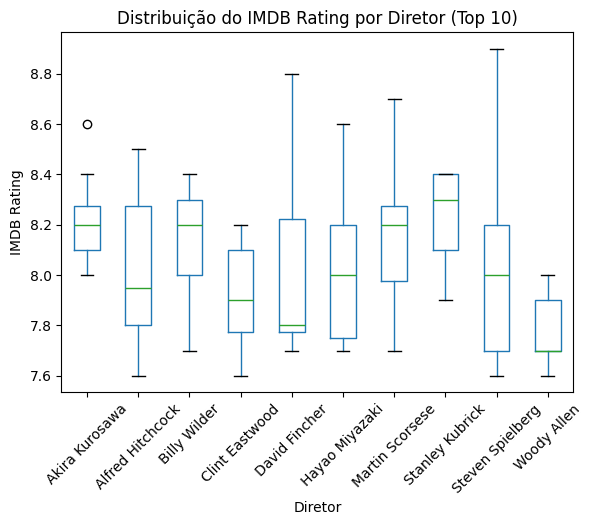

In [37]:
top_directors = df["Director"].value_counts().head(10).index
df_top_directors = df[df["Director"].isin(top_directors)]

plt.figure(figsize=(12,6))
df_top_directors.boxplot(column="IMDB_Rating", by="Director", grid=False)
plt.title("Distribuição do IMDB Rating por Diretor (Top 10)")
plt.suptitle("") 
plt.xlabel("Diretor")
plt.ylabel("IMDB Rating")
plt.xticks(rotation=45)
plt.show()

Hipótese: Alguns diretores produzem filmes com notas consistentemente mais altas

In [38]:
top_directors = df["Director"].value_counts().head(10).index
groups = [df.loc[df["Director"]==d, "IMDB_Rating"].dropna()
          for d in top_directors]

anova_f, anova_p = f_oneway(*groups)
print(f"ANOVA (Top 10 diretores): F={anova_f:.3f}, p={anova_p:.4f}")

ANOVA (Top 10 diretores): F=2.113, p=0.0362


Insights:

- O boxplot mostra que diretores como Kurosawa, Scorsese e Kubrick apresentam medianas de nota mais altas. Woody Allen aparece com a menor mediana entre os 10 analisados. A variabilidade é maior em diretores como Spielberg e Fincher, que têm filmes com notas muito distintas.

- ANOVA: F=2.113, p=0.0362 → diferenças significativas entre pelo menos alguns diretores.

<Figure size 1200x600 with 0 Axes>

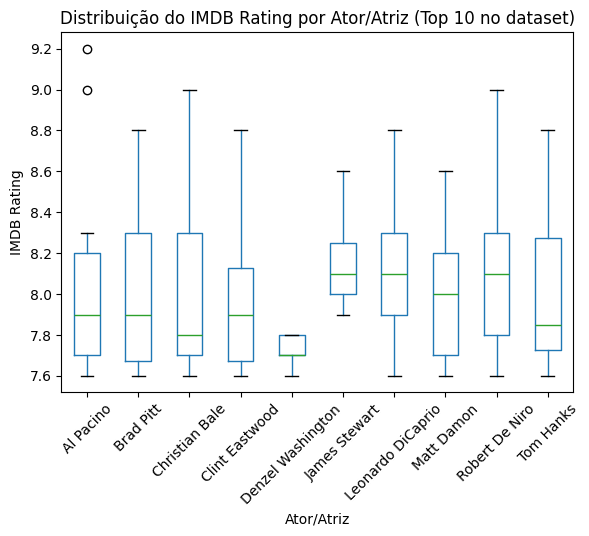

In [39]:
all_stars = pd.concat([
    df[["Star1", "IMDB_Rating"]].rename(columns={"Star1": "Star"}),
    df[["Star2", "IMDB_Rating"]].rename(columns={"Star2": "Star"}),
    df[["Star3", "IMDB_Rating"]].rename(columns={"Star3": "Star"}),
    df[["Star4", "IMDB_Rating"]].rename(columns={"Star4": "Star"}),
])
top_stars = all_stars["Star"].value_counts().head(10).index
df_top_stars = all_stars[all_stars["Star"].isin(top_stars)]

plt.figure(figsize=(12,6))
df_top_stars.boxplot(column="IMDB_Rating", by="Star", grid=False)
plt.title("Distribuição do IMDB Rating por Ator/Atriz (Top 10 no dataset)")
plt.suptitle("") 
plt.xlabel("Ator/Atriz")
plt.ylabel("IMDB Rating")
plt.xticks(rotation=45)
plt.show()

Hipótese: Certos atores/atrizes estão associados a filmes com maiores notas.

In [40]:
all_stars = pd.concat([
    df[["Star1","IMDB_Rating"]].rename(columns={"Star1":"Star"}),
    df[["Star2","IMDB_Rating"]].rename(columns={"Star2":"Star"}),
    df[["Star3","IMDB_Rating"]].rename(columns={"Star3":"Star"}),
    df[["Star4","IMDB_Rating"]].rename(columns={"Star4":"Star"}),
])
top_stars = all_stars["Star"].value_counts().head(10).index
groups = [all_stars.loc[all_stars["Star"]==s, "IMDB_Rating"].dropna()
          for s in top_stars]
anova_f, anova_p = f_oneway(*groups)
print(f"ANOVA (Top 10 atores/atrizes): F={anova_f:.3f}, p={anova_p:.4f}")

ANOVA (Top 10 atores/atrizes): F=1.080, p=0.3830


Insights:

- O boxplot mostra medianas próximas entre os atores, com sobreposição forte das distribuições. Alguns, como James Stewart e Denzel Washington, apresentam medianas um pouco mais altas e consistentes.

- ANOVA: F=1.080, p=0.3830 → não há diferença estatisticamente significativa entre as notas médias associadas a diferentes atores.

#### Preparação dos dados

In [41]:
df2 = df.copy()

df2["Runtime_min"] = df2["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)
df2["Gross_num"] = (
    df2["Gross"].astype(str).str.replace(r"[^0-9.]", "", regex=True)
       .replace("", np.nan).astype(float)
)

numeric_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
for col in ["IMDB_Rating", "Unnamed: 0"]:
    if col in numeric_cols:
        numeric_cols.remove(col)

cat_cols = df2.select_dtypes(include=["object"]).columns.tolist()
if "Genre" in cat_cols:
    cat_cols.remove("Genre")
genre_col = ["Genre"]
used_cols = list(dict.fromkeys(numeric_cols + cat_cols + genre_col))

for c in numeric_cols:
    df2[c] = pd.to_numeric(df2[c], errors="coerce")
for c in cat_cols + genre_col:
    df2[c] = df2[c].astype("object")

#### Separação dos dados - Treino/Teste

In [42]:
y = pd.to_numeric(df2["IMDB_Rating"], errors="coerce")
X = df2[used_cols].copy()
X = X.loc[:, ~X.columns.duplicated(keep="first")] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

#### Pré-Processamento

In [43]:
class GenreBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sep=","):
        self.sep = sep
        self.mlb = MultiLabelBinarizer()
    def fit(self, X, y=None):
        self.mlb.fit(self._split(X)); return self
    def transform(self, X):
        return self.mlb.transform(self._split(X))
    def get_feature_names_out(self, input_features=None):
        return np.array([f"Genre_{g}" for g in self.mlb.classes_])
    def _split(self, X):
        s = X.iloc[:,0] if isinstance(X, pd.DataFrame) else pd.Series(X[:,0])
        s = s.fillna("")
        return [[t.strip() for t in str(v).split(self.sep) if t.strip()] for v in s]

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_count=20, min_freq=0.01, other_label="Other"):
        self.min_count = min_count
        self.min_freq = float(min_freq)
        self.other_label = other_label
        self.keep_maps_ = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        X = X.fillna("Missing").astype("object")
        n = len(X)
        for col in X.columns:
            vc = X[col].value_counts(dropna=False)
            thresh = max(self.min_count, int(np.ceil(self.min_freq * n)))
            keep = set(vc[vc >= thresh].index.tolist())
            if "Missing" in vc.index:
                keep.add("Missing")
            self.keep_maps_[col] = keep
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        X = X.fillna("Missing").astype("object")
        for col in X.columns:
            keep = self.keep_maps_.get(col, set())
            X[col] = X[col].where(X[col].isin(keep), self.other_label)
        return X

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe = _make_ohe()

transformers = [
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_cols),
    ("genre", GenreBinarizer(), genre_col),
]

if len(cat_cols) > 0:
    transformers.append(
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
            ("rare", RareCategoryGrouper(min_count=20, min_freq=0.01)),
            ("ohe", ohe),
        ]), cat_cols)
    )

preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop"
)

models = {
    "Ridge": RidgeCV(alphas=np.logspace(-3, 3, 13), cv=5),
    "RF": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
res, pipes = [], {}

for name, estimator in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", estimator)])
    pipes[name] = pipe
    scores = cross_validate(
        pipe, X_train, y_train, cv=cv,
        scoring={"mae":"neg_mean_absolute_error","r2":"r2"},
        return_train_score=False
    )
    res.append({
        "model": name,
        "cv_mae": -scores["test_mae"].mean(),
        "cv_r2":  scores["test_r2"].mean()
    })

res_df = pd.DataFrame(res).sort_values(["cv_mae","cv_r2"], ascending=[True, False])
print("## Cross-validation\n", res_df)

## Cross-validation
    model    cv_mae     cv_r2
1     RF  0.151755  0.527191
0  Ridge  0.162502  0.458031



## Melhor modelo: RF
Test RMSE: 0.1968 | Test MAE: 0.1502 | Test R²: 0.4099


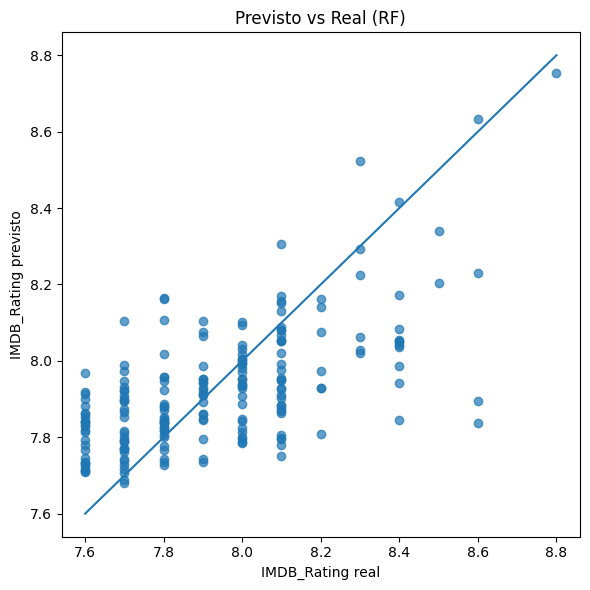

In [44]:
best_name = res_df.iloc[0]["model"]
best_pipe = pipes[best_name].fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"\n## Melhor modelo: {best_name}")
print(f"Test RMSE: {rmse:.4f} | Test MAE: {mae:.4f} | Test R²: {r2:.4f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
mn, mx = float(np.nanmin([y_test.min(), y_pred.min()])), float(np.nanmax([y_test.max(), y_pred.max()]))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("IMDB_Rating real"); plt.ylabel("IMDB_Rating previsto"); plt.title(f"Previsto vs Real ({best_name})")
plt.tight_layout(); plt.show()

- A reta de referência mostra que o RF consegue capturar bem a tendência central.

- Existe uma relação positiva clara entre valores reais e previstos, indicando que o modelo aprende o padrão da variável alvo (IMDB_Rating).

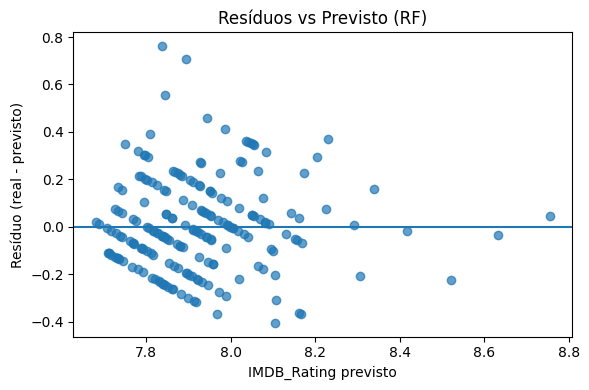

In [45]:
residuos = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuos, alpha=0.7)
plt.axhline(0)
plt.xlabel("IMDB_Rating previsto"); plt.ylabel("Resíduo (real - previsto)"); plt.title(f"Resíduos vs Previsto ({best_name})")
plt.tight_layout(); plt.show()

- O RF é razoável para capturar a tendência central das notas do IMDb, com erros baixos em termos absolutos


#### Feature importance

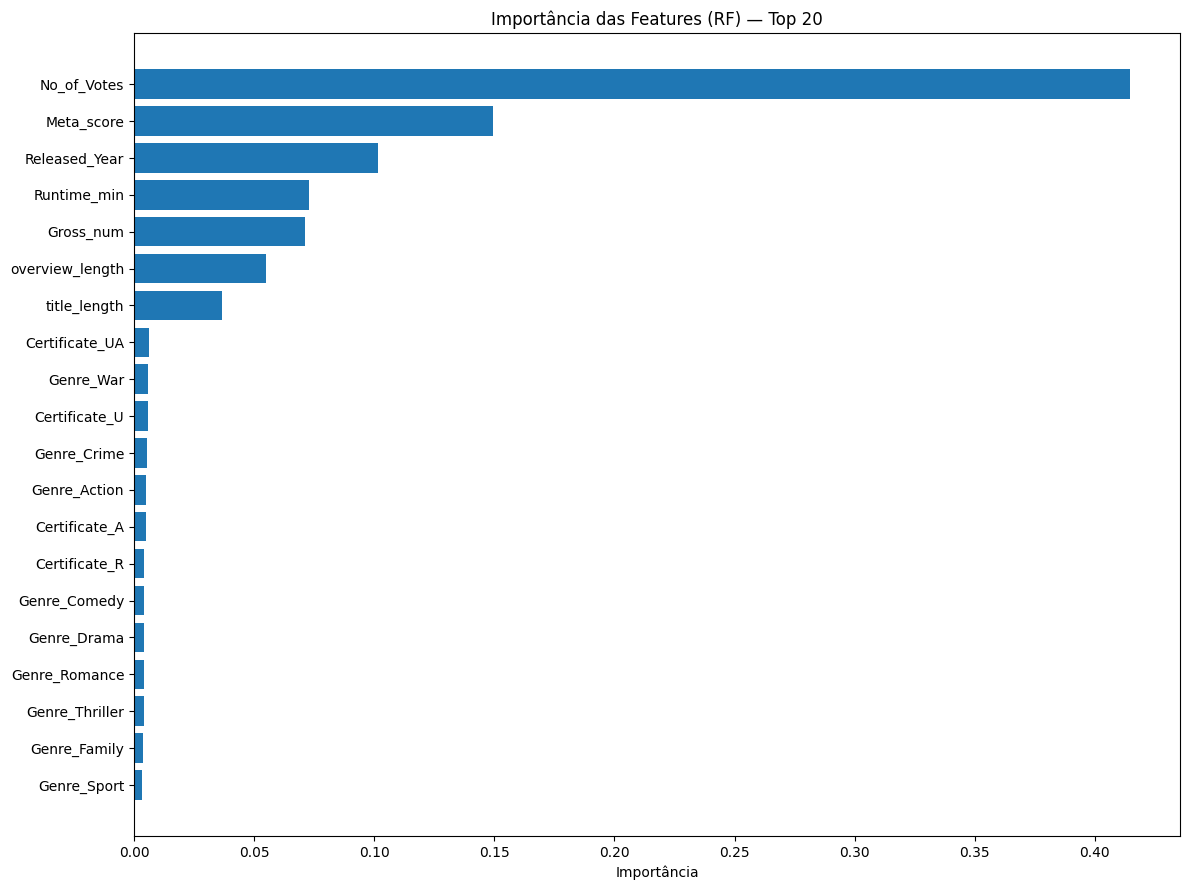

In [46]:
prep = best_pipe.named_steps["prep"]
mdl  = best_pipe.named_steps["model"]
def get_feature_names_from_ct(ct, numeric_cols, genre_col, cat_cols):
    names = []

    if len(numeric_cols) > 0:
        names.extend(list(numeric_cols))
    if "genre" in ct.named_transformers_:
        gb = ct.named_transformers_["genre"]
        names.extend(list(gb.get_feature_names_out(genre_col)))
    if "cat" in ct.named_transformers_ and len(cat_cols) > 0:
        cat_pipe = ct.named_transformers_["cat"]
        ohe = cat_pipe.named_steps["ohe"]
        names.extend(list(ohe.get_feature_names_out(cat_cols)))
    return np.array(names)

feat_names = get_feature_names_from_ct(prep, numeric_cols, genre_col, cat_cols)
if hasattr(mdl, "feature_importances_"):
    values = mdl.feature_importances_
    xlabel = "Importância"
    title = f"Importância das Features ({best_name})"
elif hasattr(mdl, "coef_"):
    values = np.abs(mdl.coef_.ravel())
    xlabel = "Magnitude |coef|"
    title = f"Magnitude dos Coeficientes ({best_name})"
else:
    raise ValueError("Modelo sem atributo de importância conhecido.")

K = 20
idx_top = np.argsort(values)[-K:]
feat_top = feat_names[idx_top]
val_top  = values[idx_top]
ord_ = np.argsort(val_top)
feat_top = feat_top[ord_]
val_top  = val_top[ord_]
plt.figure(figsize=(12, max(6, 0.45*len(feat_top))))
y = np.arange(len(feat_top))
plt.barh(y, val_top)
plt.yticks(y, feat_top)
plt.xlabel(xlabel)
plt.title(f"{title} — Top {K}")
plt.tight_layout()
plt.show()

- No_of_Votes domina a predição, mostrando que o número de votos é o principal indicador para estabilizar a nota no IMDb.

- Meta_score (crítica especializada) e Released_Year aparecem como fatores-chave adicionais.

- Runtime_min e Gross_num também contribuem, sugerindo que filmes mais longos e com maior bilheteria carregam algum sinal de qualidade.

- overview_length e title_length entram no Top 10, indicando que aspectos textuais também carregam informação preditiva.

- Certificates (UA, U, A, R) e alguns gêneros específicos (Crime, Action, Comedy, Drama) aparecem, mas com peso muito baixo individualmente.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

#### PERGUNTAS E RESPOSTAS

### Qual filme você recomendaria para uma pessoa que você não conhece?

Resposta:

- Eu recomendaria The Godfather (O Poderoso Chefão, 1972). Mesmo sendo mais antigo, é um dos filmes mais aclamados da história do cinema, com nota altíssima no IMDB, nota máxima da crítica, e um impacto cultural enorme. É uma obra-prima universal, que dificilmente deixará de impressionar qualquer espectador.

The Godfather (1972)

- IMDB Rating: 9.2 (a mais alta do seu dataset)

- Meta_score: 100 (nota máxima da crítica)

- Número de votos: 1,6 milhão (muito popular apesar da idade)

- Gênero: Crime/Drama, considerado uma das maiores obras-primas do cinema

- Impacto cultural: referência em narrativa, direção de Francis Ford Coppola e atuação de Marlon Brando e Al Pacino.

-------------------------------------------------------------------------------------------------------------------------------------------------------------

### Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Resposta:

Os fatores mais associados a alta expectativa de faturamento são:

- Popularidade (No_of_Votes)

- Gêneros com apelo massivo (Ação, Aventura, Fantasia)

- Era moderna (anos 2000+) com marketing global

- Duração épica (percepção de superprodução)

- Diretores renomados e franquias (Christopher Nolan, Peter Jackson, Coppola, Tarantino)

- Boa avaliação crítica e pública (reforça longevidade)

---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

Resposta:

A coluna Overview traz descrições que permitem extrair temas recorrentes e palavras-chave que caracterizam cada filme. A partir desses textos, é possível identificar padrões narrativos e até agrupar filmes por similaridade. Além disso, com técnicas de NLP, conseguimos inferir o gênero do filme com base no resumo: termos como “battle” e “journey” aparecem mais em aventura/fantasia, enquanto “murder” e “detective” em crime/thriller.

Na prática, sim, é possível prever o gênero a partir do Overview, mas o modelo tem melhor desempenho em gêneros frequentes (ex.: Drama, Action) e sofre em classes menores. Com técnicas mais avançadas (ex.: embeddings pré-treinados) e tratamento de desbalanceamento, essa inferência pode ser significativamente aprimorada.

Sim, é possível inferir o gênero do filme a partir da coluna Overview, porque cada gênero tem vocabulário característico.

--------------------------------------------------------------------------------------------------------------------------------------------------------------

### Explique como você faria a previsão da nota do imdb a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

Resposta:

Como eu faria a previsão da nota do IMDb:

Pré-processamento/engenharia (tudo dentro do Pipeline, sem vazamento):

- Numéricas (numeric_cols auto-detectadas): Runtime para Runtime_min(regex para extrair minutos). Gross para Gross_num(remove separadores e converte para número).

- Imputação com mediana e padronização (StandardScaler), isso ajuda o Ridge e estabiliza escalas.

Categóricas simples (cat_cols auto-detectadas, exceto Genre):

- Imputação com "Missing". RareCategoryGrouper, agrupa níveis pouco frequentes em "Other" (critério por contagem mínima e/ou frequência mínima). Isso evita explosão de dummies e overfitting em colunas de alta cardinalidade (ex.: Director, Star1–Star4). 

One-Hot Encoding (compatível com versões novas/antigas do sklearn). Genre (multirrótulo, ex.: "Drama, Crime"), GenreBinarizer com MultiLabelBinarizer para criar variáveis binárias por gênero (suporta múltiplos gêneros em uma mesma linha).

Validação e seleção do modelo:

- Treino com 5-fold cross-validation no conjunto de treino.

- Comparamos dois modelos baselines: Ridge (regressão linear com regularização L2) e RandomForestRegressor (modelo não linear, baseado em comitê de árvores).

- Critério de escolha: menor MAE médio em CV (e R² como métrica auxiliar).

Depois, re-treinamos o melhor pipeline no treino completo e avaliamos no hold-out (teste).

Quais variáveis/transformações usei e por quê?

- Released_Year, Meta_score, No_of_Votes, Runtime_min, Gross_num: numéricas relevantes e intuitivas para explicar avaliação (qualidade crítica, popularidade, duração, “força de bilheteria”, etc.). Padronizar ajuda o Ridge a não “puxar” mais para variáveis em escala grande.

- Certificate, Director, Star1…Star4, Series_Title, Overview (se presentes como object): entram pelo caminho categórico com imputação → rare grouping → OHE. O rare grouping reduz sparsidade e melhora generalização quando há muitos níveis raros.

- Genre: multirrótulo — um filme pode ser Drama e Crime ao mesmo tempo; o binarizador captura isso melhor que um OHE simples.

Que tipo de problema estamos resolvendo?

- Regressão, a variável-alvo IMDB_Rating é contínua (escala 0–10). Não é classificação.

Qual modelo melhor se aproxima dos dados? Prós e contras?

Modelo escolhido (via CV por MAE):

- Ridge: simples/interpretável; bom se relação ~linear. Contras: perde não linearidades.

- Random Forest: capta não linearidades/interações; mais robusto. Contras: menos interpretável, mais pesado.

O “melhor” é o de menor MAE médio na CV

Medidas de performance escolhidas e por quê?

- MAE (métrica principal na seleção por CV): é interpretável (“erro médio em pontos de nota do IMDb”), robusto a outliers (mais que RMSE) e fácil de comunicar.

- R² (métrica auxiliar): indica proporção da variância explicada — bom para comparar modelos em um mesmo dataset.

- RMSE (no teste/hold-out): complementa o MAE; penaliza mais erros grandes e é padrão em regressão.

--------------------------------------------------------------------------------------------------------------------------------------------------------------

### Supondo um filme com as seguintes características:

{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}


Qual seria a nota do IMDB?


Resposta:

- A predição deve ficar por volta de 8.77, com uma incerteza ~±0.2 (seu RMSE ≈ 0.19)

In [47]:
sample = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}
sdf = pd.DataFrame([sample])
sdf["Runtime_min"] = sdf["Runtime"].astype(str).str.extract(r"(\d+)").astype(float)
sdf["Gross_num"] = (
    sdf["Gross"].astype(str).str.replace(r"[^0-9.]", "", regex=True)
        .replace("", np.nan).astype(float)
)

for c in numeric_cols:
    if c in sdf.columns:
        sdf[c] = pd.to_numeric(sdf[c], errors="coerce")

for c in cat_cols + genre_col:
    if c in sdf.columns:
        sdf[c] = sdf[c].astype("object")

sample_X = sdf.reindex(columns=used_cols, fill_value=np.nan)
sample_X = sample_X.loc[:, ~sample_X.columns.duplicated(keep="first")]
pred = float(best_pipe.predict(sample_X)[0])
print(f"Predição do modelo para IMDB_Rating: {pred:.2f}")

Predição do modelo para IMDB_Rating: 8.78


----------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Transformando em pickle

In [50]:
os.makedirs("artifacts", exist_ok=True)
model_name = f"imdb_{str(best_name).lower()}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
pkl_path   = f"artifacts/{model_name}.pkl"
joblib.dump(best_pipe, pkl_path, compress=("xz", 3))
print(f"Modelo salvo em: {pkl_path}")

meta = {
    "framework": "scikit-learn",
    "model_name": str(best_name),
    "trained_at": datetime.now().isoformat(timespec="seconds"),
    "target": "IMDB_Rating",
    "features_used": {
        "numeric_cols": numeric_cols,
        "cat_cols": cat_cols,
        "genre_col": genre_col
    },
    "versions": {
        "python":  f"{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}",
        "sklearn": sklearn.__version__,
        "pandas":  pd.__version__,
        "numpy":   np.__version__
    },
    "test_metrics": {
        "rmse": float(rmse),
        "mae":  float(mae),
        "r2":   float(r2)
    }
}
meta_path = f"artifacts/{model_name}_meta.json"
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print(f"Metadados salvos em: {meta_path}")

Modelo salvo em: artifacts/imdb_rf_20250903-153913.pkl
Metadados salvos em: artifacts/imdb_rf_20250903-153913_meta.json
